# Script for CHM data preprocessing. 

## Imports and Paths definitons
watch out: data is not pushed to git. check that you have downloaded the raw data in the folder structure and named accordingly 

In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')

from utils import *
from utils import basics as bsc
from utils import processing as proc

import importlib
importlib.reload(bsc)

%load_ext autoreload
%autoreload 2


In [190]:
# PATH - Definitions
# === INPUT Paths ===

PATH_SITE1 = '../data/01_input_pipeline/01_Ebrach' 
PATH_SITE2 = '../data/01_input_pipeline/02_Wald'
PATH_SITE3 = '../data/01_input_pipeline/03_Berch'

PATH_SITE1F = '../data/01_input_pipeline/01_Ebrach/01_' 
PATH_SITE2F = '../data/01_input_pipeline/02_Wald/02_'
PATH_SITE3F = '../data/01_input_pipeline/03_Berch/03_'

PATH_S2_0102 = '../data/00_download_zips/S2_SEASONS/0102_Ebrach_Wald' # they're both in one folder
PATH_S2_03 = '../data/00_download_zips/S2_SEASONS/03_Berch'

SITE_INDEX_EBRACH = '01_'
SITE_INDEX_WALD = '02_'
SITE_INDEX_BERCH = '03_'

ALS_SUFFIX = 'ALS.tif'  # 'ALS_GT' or 'ALS_GT_Processed'
DEM_SUFFIX = 'DEM30.tif'  # 'DEM' or 'DEM_Processed'
DLT_SUFFIX = 'DLT.tif'  # 'DLTM' or 'DLTM_Processed'
FMASK_SUFFIX = 'FMA.tif'  # 'ForestMask' or 'ForestMask_Processed'

PATH_S2_Test1 = '../data/00_download_zips/S2_SEASONS/0102_Ebrach_Wald/summer/X0008_Y0004/20240101-20241231_152-243_HL_TSA_SEN2L_GRN_STM.tif'
PATH_S2_Test2 = '../data/00_download_zips/S2_SEASONS/03_Berch/spring/X0011_Y0007/20210101-20211231_060-151_HL_TSA_SEN2L_EVI_STM.tif'

# ALS_PATH1 = '../data/01_input/ALS_GT01_2024.tif' # Ebrach
# ALS_PATH2 = '../data/01_input/ALS_GT02_2024.tif' # Waldbrunn
# #S2_PATH1 = '../data/01_input/S2_Summer_Median' # S2 Summer Median
# S2_PATH1 = '../data/01_input/S2_Summer_Perc' # S2 Summer Percentiles
# #S2_TestBand = '../data/01_input/S2_Summer_Perc/' # S2 Test Band
# S2_TestBand1 = '../data/01_input/S2_Summer_Perc/X0008_Y0004_Ebrach/20240101-20241231_091-273_HL_TSA_SEN2L_BLU_STM.tif'
# S2_TestBand2 = '../data/01_input/S2_Summer_Perc/X0007_Y0004_Waldbrunn/20240101-20241231_091-273_HL_TSA_SEN2L_BLU_STM.tif'

# FOREST_MASK1 = '../data/01_input/ForestMask/fmask_01_Ebrach.tif' #ebrach
# FOREST_MASK2 = '../data/01_input/ForestMask/fmask_02_Waldbrunn.tif' #waldbrunn

# # ALS_PATH1_P = '../data/02_processed/ALS_GT01_2024_processed.tif' # Ebrach processed; we'll create this here
# # ALS_PATH2_P = '../data/02_processed/ALS_GT02_2024_processed.tif' # Waldbrunn processed; we'll create this here

# # === OUTPUT Paths ===
# OUTPUT_FOLDER = "../data/02_processed"
# VRT_FOLDER =  "../data/02_processed/S2_VRT"  
# os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# os.makedirs(VRT_FOLDER, exist_ok=True)

# To reference a file in a sibling folder (e.g., 'data') from the current folder (e.g., 'processing'), use:
# '../data/filename.ext'


## Forest Mask to S2 reprojection and cropping to ALS CHM outer dims

In [69]:
with rasterio.open(PATH_SITE1 + '/01_ALS.tif') as src:
    S2_TestBand_meta = src.meta.copy()
    S2_TestBand_meta.update({
        'driver': 'GTiff',
        'dtype': 'float32',
        'compress': 'lzw',
        'tiled': True,
        'blockxsize': 256,
        'blockysize': 256,
        'interleave': 'band'
    })

    print("Descriptions:", src.descriptions)
    print("Shape:", src.shape)
    print("Channels:", src.count)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Meta:", src.meta)

Descriptions: (None,)
Shape: (16910, 24821)
Channels: 1
CRS: EPSG:25832
Transform: | 0.50, 0.00, 601191.00|
| 0.00,-0.50, 5528384.50|
| 0.00, 0.00, 1.00|
Meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 24821, 'height': 16910, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(0.5, 0.0, 601191.0001220703,
       0.0, -0.5, 5528384.50012207)}


In [70]:
with rasterio.open(PATH_S2_Test2) as src:
    S2_TestBand_meta = src.meta.copy()
    S2_TestBand_meta.update({
        'driver': 'GTiff',
        'dtype': 'float32',
        'compress': 'lzw',
        'tiled': True,
        'blockxsize': 256,
        'blockysize': 256,
        'interleave': 'band'
    })

    print("Descriptions:", src.descriptions)
    print("Shape:", src.shape)
    print("Channels:", src.count)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Meta:", src.meta)

Descriptions: ('Q25', 'Q50', 'Q75', 'AVG', 'STD')
Shape: (6000, 6000)
Channels: 5
CRS: EPSG:25832
Transform: | 10.00, 0.00, 748279.44|
| 0.00,-10.00, 5358053.30|
| 0.00, 0.00, 1.00|
Meta: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 6000, 'height': 6000, 'count': 5, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(10.0, 0.0, 748279.43658104,
       

In [71]:
fma01, fma01_meta = transform_and_crop_to_als(PATH_SITE1 + 'FMA', PATH_SITE1 + 'ALS',  PATH_S2_Test1)

NameError: name 'transform_and_crop_to_als' is not defined

In [ ]:
def transform_and_crop_fmask_to_als(fmask_path, als_tif_path, s2_path):
    # Get target CRS, transform, and shape from S2
    with rasterio.open(s2_path) as s2_src:
        target_crs = s2_src.crs
        target_transform = s2_src.transform
        target_height = s2_src.height
        target_width = s2_src.width
        target_meta = s2_src.meta.copy()
        target_meta.update({
            'driver': 'GTiff',
            'dtype': 'uint8',
            'compress': 'lzw',
            'tiled': True,
            'blockxsize': 256,
            'blockysize': 256,
            'interleave': 'band',
            'count': 1,
            'nodata': 0
        })

    # Get the bounds of the ALS raster (for cropping)
    with rasterio.open(als_tif_path) as als_src:
        als_bounds = als_src.bounds

    # Read and reproject/crop the forest mask
    with rasterio.open(fmask_path) as src:
        data = src.read(1)
        data_reprojected = np.zeros((target_height, target_width), dtype=np.uint8)
        reproject(
            source=data,
            destination=data_reprojected,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )

    # Mask out everything outside the ALS bounds
    with rasterio.open(s2_path) as s2_src:
        s2_window = rasterio.windows.from_bounds(*als_bounds, transform=target_transform)
        s2_window = s2_window.round_offsets().round_lengths()
        cropped_data = data_reprojected[
            int(s2_window.row_off):int(s2_window.row_off + s2_window.height),
            int(s2_window.col_off):int(s2_window.col_off + s2_window.width)
        ]
        cropped_meta = target_meta.copy()
        cropped_meta.update({
            'height': cropped_data.shape[0],
            'width': cropped_data.shape[1],
            'transform': rasterio.windows.transform(s2_window, target_transform)
        })

    output_path = os.path.join(OUTPUT_FOLDER, os.path.basename(fmask_path))
    with rasterio.open(output_path, 'w', **cropped_meta) as dst:
        dst.write(cropped_data, 1)

    return cropped_data, cropped_meta

# Example usage:
forest_mask1_reprojected, forest_mask1_meta = transform_and_crop_fmask_to_als(FOREST_MASK1, ALS_PATH1, S2_TestBand1)
forest_mask2_reprojected, forest_mask2_meta = transform_and_crop_fmask_to_als(FOREST_MASK2, ALS_PATH2, S2_TestBand2)

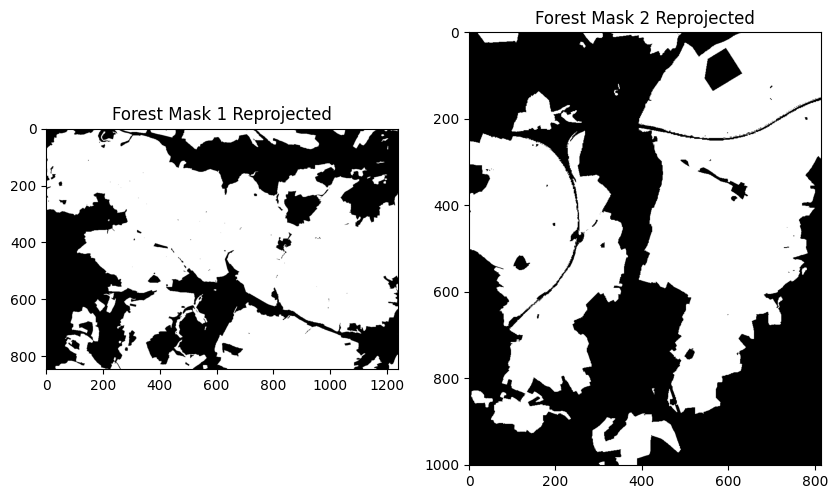

Forest Mask 1 - Mean: 0.6427774063088755 Std: 0.47918118937173476
Forest Mask 2 - Mean: 0.5151268016115009 Std: 0.4997711274903805


In [ ]:
#plot the reprojected forest masks
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(forest_mask1_reprojected, cmap='gray')
plt.title('Forest Mask 1 Reprojected')
plt.subplot(1, 2, 2)
plt.imshow(forest_mask2_reprojected, cmap='gray')
plt.title('Forest Mask 2 Reprojected')
plt.show()

# print the mean and std of the reprojected forest masks
print("Forest Mask 1 - Mean:", np.mean(forest_mask1_reprojected), "Std:", np.std(forest_mask1_reprojected))
print("Forest Mask 2 - Mean:", np.mean(forest_mask2_reprojected), "Std:", np.std(forest_mask2_reprojected))

In [ ]:
fmask1 = bsc.read_tif_as_array(FOREST_MASK1)
forest_mask1_reprojected = bsc.read_tif_as_array('../data/02_processed/fmask_01_Ebrach.tif')

✅ Loaded fmask_01_Ebrach.tif: shape=(6001, 6001), CRS=EPSG:32632, GSD=10.00 x 10.00 metre
Band names: (None,)
✅ Loaded fmask_01_Ebrach.tif: shape=(846, 1241), CRS=EPSG:25832, GSD=10.00 x 10.00 metre
Band names: (None,)


--> nice, we can now work with that.

## ALS data ingest and Preprocessing

### Raw Data checking

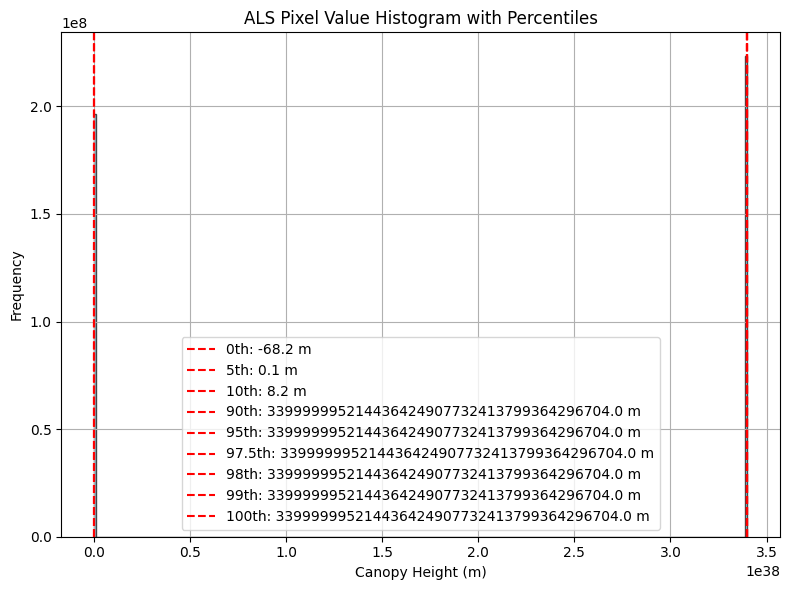

In [12]:
# plot_ALS_histogram(PATH_SITE1 + '/01_ALS.tif')

--> we see: negative value and some vast majority of really big numbers. this needs some cleanup first.

### ALS outlier removal

In [111]:
ALS_PATH1_P = proc.clean_als_tif(PATH_SITE1F + ALS_SUFFIX, PATH_SITE1)
ALS_PATH2_P = proc.clean_als_tif(PATH_SITE2F + ALS_SUFFIX, PATH_SITE2)
# for Berch, we already have a ready CHM 
ALS_PATH3_P = PATH_SITE3F + ALS_SUFFIX  # Use the existing CHM directly, no need to cleanup, see histogram below.

✅  Output file already exists: ../data/01_input_pipeline/01_Ebrach/01_ALS_P.tif. Use override=True to overwrite.
✅  Output file already exists: ../data/01_input_pipeline/02_Wald/02_ALS_P.tif. Use override=True to overwrite.


### Histogram after outlier filtering: looks much better :)

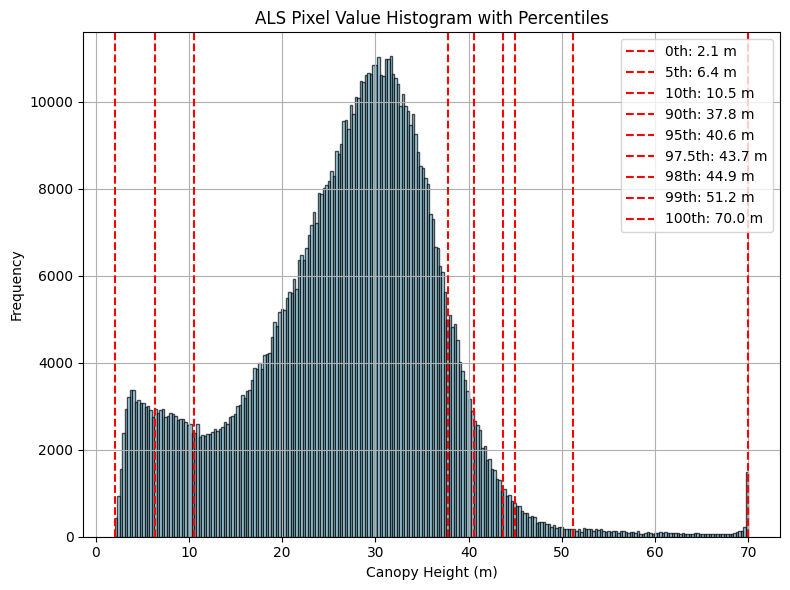

In [112]:
#plot_ALS_histogram(ALS_PATH1_P)
#plot_ALS_histogram(ALS_PATH2_P)
plot_ALS_histogram(ALS_PATH3_P)

## Sentinel-2 data ingest and pre-processing

### Conversion to .vrt in order to handle each band nicely

In [30]:
# === CONFIG ===
recursive = True

proc.create_s2_vrt(PATH_S2_0102, PATH_S2_0102 + '/S2VRT/' , recursive)
proc.create_s2_vrt(PATH_S2_03, PATH_S2_03 + '/S2VRT/', recursive)

Creating NDV_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating EVI_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating RED_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating RE1_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating SW1_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating GRN_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating RE2_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating SW2_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating BNR_STM VRT for spring with 6 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating RE3_STM VR

### Align the S2 to ALS data

how to do alignment:
- first, we have to check for the same Map Projection.
- alignment and cropping:
    - polygon cutline around the images: downside: is very memory heavy (30GB)
    - instead, we crop an outer bounding box over the overlapping area for each ALS Site. 
- then, later we can drop parts where not all layers have plausible pixel values

### check projections

In [89]:
#VRT_FOLDER = PATH_S2_0102 + '/S2VRT/'  
VRT_FOLDER = PATH_S2_03 + '/S2VRT/spring/'
# check the projection of s2 and als 
    
proc.compare_raster_metadata(ALS_PATH1_P, os.path.join(VRT_FOLDER, "RED_STM.vrt"))


--- Raster A: 01_ALS_P.tif ---
Descriptions: (None,)
Shape: (16910, 24821)
Band count: 1
CRS: EPSG:25832
Transform: | 0.50, 0.00, 601191.00|
| 0.00,-0.50, 5528384.50|
| 0.00, 0.00, 1.00|

--- Raster B: RED_STM.vrt ---
Descriptions: ('Q25', 'Q50', 'Q75', 'AVG', 'STD')
Shape: (18000, 12000)
Band count: 5
CRS: EPSG:25832
Transform: | 10.00, 0.00, 748279.44|
| 0.00,-10.00, 5358053.30|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
❌ Transformations do not match!


**🆒, both share the same coordinate system. the two diff. transformation, we'll take of that later when doing the resampling.**

### bounding box cropping around ALS dims

In [113]:
# site 1: 
proc.crop_and_stack_vrts_to_als(ALS_PATH1_P, PATH_S2_0102 + '/S2VRT/', PATH_SITE1 + '/S2/', override=False)
# site 2:
proc.crop_and_stack_vrts_to_als(ALS_PATH2_P, PATH_S2_0102 + '/S2VRT/', PATH_SITE2 + '/S2/', override=False)
# site 3:
proc.crop_and_stack_vrts_to_als(ALS_PATH3_P, PATH_S2_03 + '/S2VRT/', PATH_SITE3 + '/S2/', override=True)

[DEBUG] ALS bounds: BoundingBox(left=601191.0001220703, bottom=5519929.50012207, right=613601.5001220703, top=5528384.50012207)
[DEBUG] ALS CRS: EPSG:25832
[DEBUG] VRT folder: ../data/00_download_zips/S2_SEASONS/0102_Ebrach_Wald/S2VRT/
[DEBUG] Output folder: ../data/01_input_pipeline/01_Ebrach/S2/
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/RED_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/EVI_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/NDV_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/GRN_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/SW1_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/RE1_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/NBR_STM_cropped.tif already exists.
[SKIP] ../data/01_input_pipeline/01_Ebrach/S2/spring/BLU_STM_cropped.tif alrea

In [114]:
proc.compare_raster_metadata(ALS_PATH1_P, os.path.join(PATH_SITE1 + '/S2/summer', 'RED_STM_cropped.tif'))
proc.compare_raster_metadata(ALS_PATH3_P, os.path.join(PATH_SITE3 + '/S2/summer', 'RED_STM_cropped.tif'))


--- Raster A: 01_ALS_P.tif ---
Descriptions: (None,)
Shape: (16910, 24821)
Band count: 1
CRS: EPSG:25832
Transform: | 0.50, 0.00, 601191.00|
| 0.00,-0.50, 5528384.50|
| 0.00, 0.00, 1.00|

--- Raster B: RED_STM_cropped.tif ---
Descriptions: ('Q25', 'Q50', 'Q75', 'AVG', 'STD')
Shape: (846, 1241)
Band count: 5
CRS: EPSG:25832
Transform: | 10.00, 0.00, 601191.00|
| 0.00,-9.99, 5528384.50|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
❌ Transformations do not match!

--- Raster A: 03_ALS.tif ---
Descriptions: (None,)
Shape: (1869, 2128)
Band count: 1
CRS: EPSG:25832
Transform: | 10.01, 0.00, 784186.31|
| 0.00,-10.01, 5284305.78|
| 0.00, 0.00, 1.00|

--- Raster B: RED_STM_cropped.tif ---
Descriptions: ('Q25', 'Q50', 'Q75', 'AVG', 'STD')
Shape: (1870, 2129)
Band count: 5
CRS: EPSG:25832
Transform: | 10.00, 0.00, 784186.31|
| 0.00,-10.00, 5284305.78|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
❌ Transformations do not match!


### stack the cropped S2 back into one .tif with 13 channels x 5 stats = 65 channels per season

In [116]:
S2Stack01 = proc.stack_site_vrts_to_multiband(PATH_SITE1 + '/S2/')
S2Stack02 = proc.stack_site_vrts_to_multiband(PATH_SITE2 + '/S2/')
S2Stack03 = proc.stack_site_vrts_to_multiband(PATH_SITE3 + '/S2/',override=True)

✅ Loaded existing stacked file: ../data/01_input_pipeline/01_Ebrach/S2/spring/S2_stacked.tif
✅ Loaded existing stacked file: ../data/01_input_pipeline/01_Ebrach/S2/summer/S2_stacked.tif
✅ Loaded existing stacked file: ../data/01_input_pipeline/01_Ebrach/S2/autumn/S2_stacked.tif
✅ Loaded existing stacked file: ../data/01_input_pipeline/02_Wald/S2/spring/S2_stacked.tif
✅ Loaded existing stacked file: ../data/01_input_pipeline/02_Wald/S2/summer/S2_stacked.tif
✅ Loaded existing stacked file: ../data/01_input_pipeline/02_Wald/S2/autumn/S2_stacked.tif
✅ Stacked 13 bands with 5 channels each into ../data/01_input_pipeline/03_Berch/S2/spring/S2_stacked.tif
✅ Stacked 13 bands with 5 channels each into ../data/01_input_pipeline/03_Berch/S2/summer/S2_stacked.tif
✅ Stacked 13 bands with 5 channels each into ../data/01_input_pipeline/03_Berch/S2/autumn/S2_stacked.tif


### little sanity check:

In [55]:
S2_site1_np = bsc.read_multiband_tif_as_stack(S2Stack01['summer'])

In [52]:
S2_site1_np.shape

(13, 5, 846, 1241)

In [54]:
# test if band names are correct
with rasterio.open(S2Stack01['summer']) as s2_src:
    s2np = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
    s2res_x, s2res_y = s2_src.res  # (pixel width, pixel height in coordinate units)
    s2crs = s2_src.crs
    # Print band (channel) descriptions if available
    print(s2_src.descriptions)

('BLU_Q25', 'BLU_Q50', 'BLU_Q75', 'BLU_AVG', 'BLU_STD', 'BNR_Q25', 'BNR_Q50', 'BNR_Q75', 'BNR_AVG', 'BNR_STD', 'EVI_Q25', 'EVI_Q50', 'EVI_Q75', 'EVI_AVG', 'EVI_STD', 'GRN_Q25', 'GRN_Q50', 'GRN_Q75', 'GRN_AVG', 'GRN_STD', 'NBR_Q25', 'NBR_Q50', 'NBR_Q75', 'NBR_AVG', 'NBR_STD', 'NDV_Q25', 'NDV_Q50', 'NDV_Q75', 'NDV_AVG', 'NDV_STD', 'NIR_Q25', 'NIR_Q50', 'NIR_Q75', 'NIR_AVG', 'NIR_STD', 'RE1_Q25', 'RE1_Q50', 'RE1_Q75', 'RE1_AVG', 'RE1_STD', 'RE2_Q25', 'RE2_Q50', 'RE2_Q75', 'RE2_AVG', 'RE2_STD', 'RE3_Q25', 'RE3_Q50', 'RE3_Q75', 'RE3_AVG', 'RE3_STD', 'RED_Q25', 'RED_Q50', 'RED_Q75', 'RED_AVG', 'RED_STD', 'SW1_Q25', 'SW1_Q50', 'SW1_Q75', 'SW1_AVG', 'SW1_STD', 'SW2_Q25', 'SW2_Q50', 'SW2_Q75', 'SW2_AVG', 'SW2_STD')


In [56]:
s2np.shape

(65, 846, 1241)

## Now, we're ready for resampling

### loading the rasters first and check the GSD 

In [117]:

# Load S2 and merged ALS data for both sites and combine them in an array
#s2_np, als_np, bands = bsc.load_rasters(S2Stack01['summer'], ALS_PATH1_P)
s2_np3, als_np3, bands3 = bsc.load_rasters(S2Stack03['summer'], ALS_PATH3_P)
#s2_np2, als_np2 = bsc.load_rasters(S2Stack02['summer'], ALS_PATH2_P)

# # do one file with both sites but give them a new dimension
# s2_combined = np.stack([s2_np, s2_np2], axis=0)  # shape: (sites, bands, height, width)
# als_combined = np.stack([als_np, als_np2], axis=0)  # shape: (sites, height, width)

✅ Loaded S2: (13, 1870, 2129), ALS: (1869, 2128)
S2_stacked.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 10.00 metre
  Band names: ('BLU_Q50', 'BNR_Q50', 'EVI_Q50', 'GRN_Q50', 'NBR_Q50', 'NDV_Q50', 'NIR_Q50', 'RE1_Q50', 'RE2_Q50', 'RE3_Q50', 'RED_Q50', 'SW1_Q50', 'SW2_Q50')

03_ALS.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.01 x 10.01 metre



💡 We still have the same CRS, however GSD is not the same, we'll tackle this now

### Now let's to the resampling.
Since rasterio doesnt provide a percentile resampling method, we do the following:
1. Take the preprocessed ALS data (outlier already removed, values are in range[0,75])
2. Clip (=saturate) the upper end above the 98th (can be parametrized) percentile.
3. Then, use Rasterio.Resampling and use the method ‚max'. Since it only takes max, mean, median, etc. but no custom quantiles, let’s just do this step manually beforehand. Only downside is, that we clip at the overall 98th percentile of the whole image, not for each window (20x20=400 pixel per 10x10m). However, if the goal is to filter out scatter/noise, this should be fine for a first approach, the error is probably negligible.

[See Rasterio Resampling documentation](https://rasterio.readthedocs.io/en/latest/topics/resampling.html) 


In [160]:
als_resampled1 = proc.resample_ALS_to_S2(ALS_PATH1_P, S2Stack01['summer'], percentile=98)
als_resampled2 = proc.resample_ALS_to_S2(ALS_PATH2_P, S2Stack02['summer'], percentile=98)
als_resampled3 = proc.resample_ALS_to_S2(ALS_PATH3_P, S2Stack03['summer'], percentile=100) # few pixel shift to match original projection

✅ Resampled ALS to S2 shape: (846, 1241), S2 shape: (846, 1241); percentile: 98th
✅ Resampled ALS to S2 shape: (1002, 815), S2 shape: (1002, 815); percentile: 98th
✅ Resampled ALS to S2 shape: (1870, 2129), S2 shape: (1870, 2129); percentile: 100th


In [161]:
#print the count of nan in the resampled ALS data
print(f"ALS Resampled 1 NaN count: {np.isnan(als_resampled1).sum()}")
print(f"ALS Resampled 2 NaN count: {np.isnan(als_resampled2).sum()}")
print(f"ALS Resampled 3 NaN count: {np.isnan(als_resampled3).sum()}")

ALS Resampled 1 NaN count: 551421
ALS Resampled 2 NaN count: 372580
ALS Resampled 3 NaN count: 3020980


In [162]:
ALS_PATH1_RES = proc.write_resampled_als(als_resampled1, S2Stack01['summer'], PATH_SITE1F + "CHM.tif")
ALS_PATH2_RES = proc.write_resampled_als(als_resampled2, S2Stack02['summer'], PATH_SITE2F + "CHM.tif")
ALS_PATH3_RES = proc.write_resampled_als(als_resampled3, S2Stack03['summer'], PATH_SITE3F + "CHM.tif") # few pixel shift to match original projection
#ALS_PATH3_P #here we have it already at the needed grid

✅ Resampled ALS saved to: ../data/01_input_pipeline/01_Ebrach/01_CHM.tif
✅ Resampled ALS saved to: ../data/01_input_pipeline/02_Wald/02_CHM.tif
✅ Resampled ALS saved to: ../data/01_input_pipeline/03_Berch/03_CHM.tif


cool, now that we have two spatially aligned images with the same resolution, we can dig deeper. let's have some insights into our data. --> see 02_data_insights


## Aux Layer Transformations

### FMASK Transform

In [164]:
#proc.compare_raster_metadata(ALS_PATH1_RES, os.path.join(PATH_SITE1F + FMASK_SUFFIX))
proc.compare_raster_metadata(ALS_PATH2_RES, os.path.join(PATH_SITE2F + FMASK_SUFFIX))
#proc.compare_raster_metadata(ALS_PATH3_RES, os.path.join(PATH_SITE3F + FMASK_SUFFIX))


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: 02_FMA.tif ---
Descriptions: (None,)
Shape: (6001, 6001)
Band count: 1
CRS: EPSG:32632
Transform: | 10.00, 0.00, 508270.00|
| 0.00,-10.00, 5538060.00|
| 0.00, 0.00, 1.00|

--- Comparison ---
❌ CRS Projections do not match!
❌ Transformations do not match!


In [165]:
fma1p, meta, PATH_FMA1_P = proc.transform_and_crop_to_als(PATH_SITE1F + FMASK_SUFFIX, ALS_PATH1_RES, S2Stack01['summer'], PATH_SITE1)
fma2p, meta, PATH_FMA2_P = proc.transform_and_crop_to_als(PATH_SITE2F + FMASK_SUFFIX, ALS_PATH2_RES, S2Stack02['summer'], PATH_SITE2)
fma3p, meta, PATH_FMA3_P = proc.transform_and_crop_to_als(PATH_SITE3F + FMASK_SUFFIX, ALS_PATH3_RES, S2Stack03['summer'], PATH_SITE3)

In [166]:
#proc.compare_raster_metadata(ALS_PATH1_RES, PATH_FMA1_P)
proc.compare_raster_metadata(ALS_PATH2_RES, PATH_FMA2_P)
proc.compare_raster_metadata(ALS_PATH3_RES, PATH_FMA3_P)


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: 02_FMA_P.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
✅ Transformations match!

--- Raster A: 03_CHM.tif ---
Descriptions: (None,)
Shape: (1870, 2129)
Band count: 1
CRS: EPSG:25832
Transform: | 10.00, 0.00, 784186.31|
| 0.00,-10.00, 5284305.78|
| 0.00, 0.00, 1.00|

--- Raster B: 03_FMA_P.tif ---
Descriptions: (None,)
Shape: (1870, 2129)
Band count: 1
CRS: EPSG:25832
Transform: | 10.00, 0.00, 784186.31|
| 0.00,-10.00, 5284305.78|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
✅ Transformations match!


In [202]:
for arr, name in zip([fma1p, fma2p, fma3p], ['fma1p', 'fma2p', 'fma3p']):
    nan_count = np.isnan(arr).sum()
    mean_val = np.nanmean(arr)
    print(f"{name}: NaN count = {nan_count}, Mean = {mean_val}")

fma1p: NaN count = 0, Mean = 0.6424402268436764
fma2p: NaN count = 0, Mean = 0.5151268016115009
fma3p: NaN count = 0, Mean = 0.5059403752106761


In [ ]:
plot an overlay of two raster layers ALS_PATH2_RES, PATH_FMA2_P 
    

### DLT Transform

In [183]:
proc.compare_raster_metadata(ALS_PATH2_RES, os.path.join(PATH_SITE2F + DLT_SUFFIX))


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: 02_DLT.tif ---
Descriptions: (None,)
Shape: (10134, 10129)
Band count: 1
CRS: EPSG:25832
Transform: | 10.27, 0.00, 449191.29|
| 0.00,-10.27, 5552700.14|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
❌ Transformations do not match!


In [186]:
dlt1p, meta, PATH_DLT1_P = proc.transform_and_crop_to_als(PATH_SITE1F + DLT_SUFFIX, ALS_PATH1_RES, S2Stack01['summer'], PATH_SITE1)
dlt2p, meta, PATH_DLT2_P = proc.transform_and_crop_to_als(PATH_SITE2F + DLT_SUFFIX, ALS_PATH2_RES, S2Stack02['summer'], PATH_SITE2)
dlt3p, meta, PATH_DLT3_P = proc.transform_and_crop_to_als(PATH_SITE3F + DLT_SUFFIX, ALS_PATH3_RES, S2Stack03['summer'], PATH_SITE3)

In [188]:
proc.compare_raster_metadata(ALS_PATH2_RES, S2Stack02['summer'])
proc.compare_raster_metadata(ALS_PATH2_RES, PATH_DLT2_P)


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: S2_stacked.tif ---
Descriptions: ('BLU_Q25', 'BLU_Q50', 'BLU_Q75', 'BLU_AVG', 'BLU_STD', 'BNR_Q25', 'BNR_Q50', 'BNR_Q75', 'BNR_AVG', 'BNR_STD', 'EVI_Q25', 'EVI_Q50', 'EVI_Q75', 'EVI_AVG', 'EVI_STD', 'GRN_Q25', 'GRN_Q50', 'GRN_Q75', 'GRN_AVG', 'GRN_STD', 'NBR_Q25', 'NBR_Q50', 'NBR_Q75', 'NBR_AVG', 'NBR_STD', 'NDV_Q25', 'NDV_Q50', 'NDV_Q75', 'NDV_AVG', 'NDV_STD', 'NIR_Q25', 'NIR_Q50', 'NIR_Q75', 'NIR_AVG', 'NIR_STD', 'RE1_Q25', 'RE1_Q50', 'RE1_Q75', 'RE1_AVG', 'RE1_STD', 'RE2_Q25', 'RE2_Q50', 'RE2_Q75', 'RE2_AVG', 'RE2_STD', 'RE3_Q25', 'RE3_Q50', 'RE3_Q75', 'RE3_AVG', 'RE3_STD', 'RED_Q25', 'RED_Q50', 'RED_Q75', 'RED_AVG', 'RED_STD', 'SW1_Q25', 'SW1_Q50', 'SW1_Q75', 'SW1_AVG', 'SW1_STD', 'SW2_Q25', 'SW2_Q50', 'SW2_Q75', 'SW2_AVG', 'SW2_STD')
Shape: (1002, 815)
Band count: 65
CRS: EPSG:25832
Tr

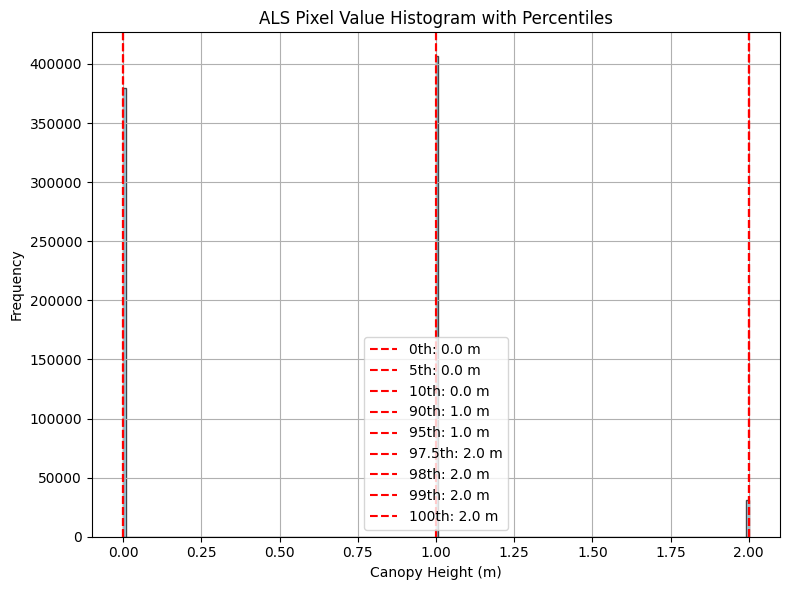

In [187]:
plot_ALS_histogram(PATH_DLT2_P)
#plot_ALS_histogram(PATH_SITE2F + DLT_SUFFIX)

### DEM Transform

In [191]:
proc.compare_raster_metadata(ALS_PATH2_RES, os.path.join(PATH_SITE2F + DEM_SUFFIX))


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: 02_DEM30.tif ---
Descriptions: (None,)
Shape: (363, 289)
Band count: 1
CRS: COMPD_CS["ETRS89 / UTM zone 32N + EGM96 height",PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]],VERT_CS["EGM96 height",VERT_DATUM["EGM96 geo

In [ ]:
import os

def resample_and_crop_dem_to_als(dem30_path, als_ref_path, output_folder, resampling_method=Resampling.bilinear):
    """
    Resample DEM from 30m to 10m resolution and crop to ALS reference raster.
    Output filename will be similar to input, but with 'DEM10' instead of 'DEM30'.
    """
    # Generate output filename
    dem30_filename = os.path.basename(dem30_path)
    dem10_filename = dem30_filename.replace('DEM30', 'DEM10')
    output_path = os.path.join(output_folder, dem10_filename)

    # Open ALS reference to get target shape, transform, crs
    with rasterio.open(als_ref_path) as als_src:
        target_crs = als_src.crs
        target_transform = als_src.transform
        target_height = als_src.height
        target_width = als_src.width
        target_meta = als_src.meta.copy()
        target_meta.update({
            'driver': 'GTiff',
            'dtype': 'float32',
            'compress': 'lzw',
            'tiled': True,
            'blockxsize': 256,
            'blockysize': 256,
            'interleave': 'band',
            'count': 1,
            'nodata': 0
        })

    # Open DEM30 and reproject/resample to ALS grid
    with rasterio.open(dem30_path) as dem_src:
        dem_data = dem_src.read(1)
        dem10 = np.zeros((target_height, target_width), dtype=np.float32)
        reproject(
            source=dem_data,
            destination=dem10,
            src_transform=dem_src.transform,
            src_crs=dem_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=resampling_method
        )

    # Write output
    with rasterio.open(output_path, 'w', **target_meta) as dst:
        dst.write(dem10, 1)

    return dem10, target_meta, output_path


In [199]:
dem1p, meta, PATH_DEM1_P = proc.resample_and_crop_dem_to_als(PATH_SITE1F + DEM_SUFFIX, ALS_PATH1_RES, PATH_SITE1)
dem2p, meta, PATH_DEM2_P = proc.resample_and_crop_dem_to_als(PATH_SITE2F + DEM_SUFFIX, ALS_PATH2_RES, PATH_SITE2)
dem3p, meta, PATH_DEM3_P = proc.resample_and_crop_dem_to_als(PATH_SITE3F + DEM_SUFFIX, ALS_PATH3_RES, PATH_SITE3)

In [200]:
proc.compare_raster_metadata(ALS_PATH2_RES, PATH_DEM2_P)


--- Raster A: 02_CHM.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Raster B: 02_DEM10.tif ---
Descriptions: (None,)
Shape: (1002, 815)
Band count: 1
CRS: EPSG:25832
Transform: | 9.99, 0.00, 556993.50|
| 0.00,-10.00, 5513231.00|
| 0.00, 0.00, 1.00|

--- Comparison ---
✅ CRS Projections match!
✅ Transformations match!


# That's it for all resampling and cropping!